# Experiments with Hough transform

Hough transform that operates in $(k, b)$ parameter space is needed. Rectangular images are supposed to be zero-padded in the direction of smaller dimension, as it is suggested by [Brady, M.L., 1998].

In [1]:
# Necessary includes

# Scikit-image (for image storing)
from skimage import io
from skimage import color
from skimage import filters
# NumPy (for fast vectorised computations)
import numpy as np
# Matplotlib (for inline image rendering)
import matplotlib.pyplot as plot

In [2]:
# Experimental placeholder IM_PATH
#
# Needs to be replaced with a varibale set by end user
# in production version of the program

IM_PATH = '../sample_images/NotreDamedeReims.jpg'

## Auxiliary toolset

In [3]:
def render_image(image, grayscale=False):
    plot.figure(figsize=(10, 10))
    if grayscale:
        plot.imshow(image, cmap=plot.cm.gray)
    else:
        plot.imshow(image)
    return

In [4]:
def add_padding(image, left=1, right=1, top=1, bottom=1, filler='#000000'):
    """
    Add padding to the image
    
    Parameters
    ----------
    image  : NumPy array
             Scikit-image image.
    left   : int
             Number of padded pixels from the left.
    right  : int
             Number of padded pixels from the right.
    top    : int
             Number of padded pixels from the top.
    bottom : int
             Number of padded pixels from the bottom.
    filler : string ('plume' or RGB colour as a 6-digit hex code)
             If 'plume', the padding will be filled with colours of the
             nearest border which will be linearly interpolated at corners.
             Otherwise, it will be filled with the specified colour.
    
    Padding is filled with <filler> colour.
    
    Returns
    -------
    padded_image : NumPy array
                   Scikit-image image with padding.
    """
    # 1. Create a billet for the padded image
    if filler == 'plume':
        padded_image = np.zeros((top + image.shape[0] + bottom, left + image.shape[1] + right, image.shape[2]), dtype='int')
        padded_image[top:top+image.shape[0], left:left+image.shape[1], :] = image
        # Fill left, right, top and bottom stripes
        for _ in range(top):
            padded_image[_, left:left+image.shape[1], :] = padded_image[top, left:left+image.shape[1], :]
        for _ in range(top+image.shape[0], padded_image.shape[0]):
            padded_image[_, left:left+image.shape[1], :] = padded_image[top+image.shape[0]-1, left:left+image.shape[1], :]
        for _ in range(left):
            padded_image[top:top+image.shape[0], _, :] = padded_image[top:top+image.shape[0], left, :]
        for _ in range(left+image.shape[1], padded_image.shape[1]):
            padded_image[top:top+image.shape[0], _, :] = padded_image[top:top+image.shape[0], left+image.shape[1]-1, :]
        # Fill corners
        
    return padded_image

## Step 1. Image load

We'll utilise Scikit-image.

In [5]:
image = io.imread(IM_PATH)

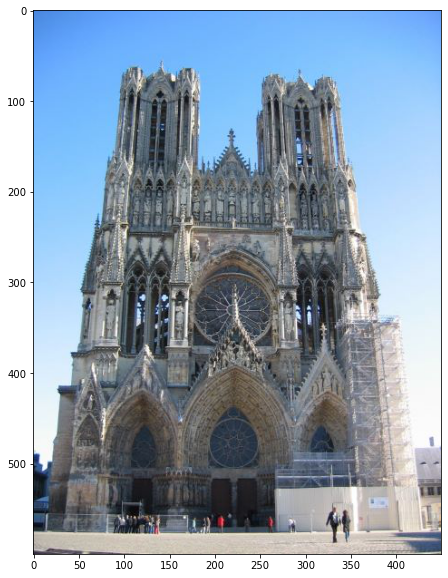

In [6]:
render_image(image)

## Step 2. Edge detection

With $3 \times 3$ Scharr operator.

In [7]:
edges = filters.scharr(color.rgb2gray(image))
edges[np.where(edges > filters.threshold_otsu(edges))] = 255
edges[np.where(edges != 255)] = 0
edges = edges.astype('int')

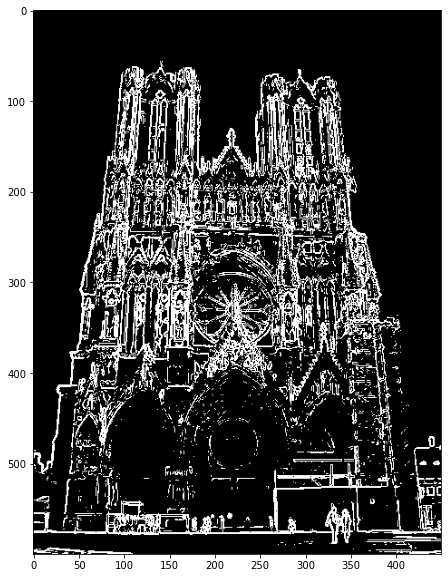

In [8]:
render_image(edges, grayscale=True)

## Step 3. Apply Hough

Hough transform is aimed at straight line detection. We represent lines in their classical parametrisation:

$$y = kx + b$$

In order to avoid infinitely large values of $k$ we distinguish between "predominantly vertical" and "predominantly horizontal" lines. Thus, the absolute values of $k$ never exceed one.

In [9]:
def hough_kb(image):
    # 1. Initialise parameter spaces
    k_step_h = 1 / image.shape[1]
    voters_h = np.zeros((2 * image.shape[1], image.shape[0] + image.shape[1]), dtype='int')
    # ... vertical
    # 2. Saturate Hough spaces
    for point in np.array(np.where(edges == 255)).T:
        k_h = -1.0
        for step_i in range(voters_h.shape[0]):
            voters_h[step_i][int(point[1] - k_h * point[0])] += 1
            k_h += k_step_h
        # ... vertical
    return voters_h

In [10]:
voters_h = hough_kb(edges)

In [11]:
voters_h

array([[  0,   0,   0, ...,   1,   1,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       ...,
       [217, 105, 105, ..., 107,  95, 103],
       [218, 109,  95, ..., 100,  95, 109],
       [206,  96, 109, ...,  90, 106, 113]])

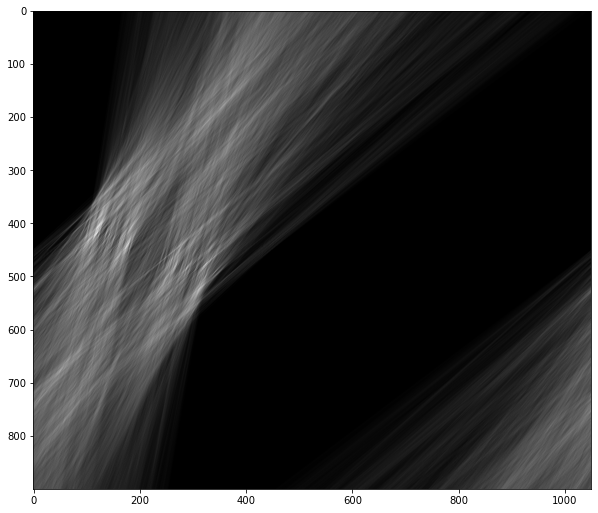

In [12]:
render_image(voters_h / np.max(voters_h), grayscale=True)